# Scoring notebook

This is the scoring notebook for the data driven competition at CMF 2022. You can change cells with `### YOUR CODE HERE` line, all other cells are read-only. However, you can add new cells to organize your code in a convenient way.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

Let us load the dataset. Columns in the test (public as well as private) dataset are equivalent to the train dataset.

In [2]:
dataset = pd.read_csv('dataset.zip', index_col=0, header=[0, 1])
dataset.rename(
    columns={
        'Unnamed: 209_level_1': 'count',
        'Unnamed: 210_level_1': 'price',
    },
    level = 1,
    inplace = True
)
dataset.head()

timestamp_second bid_price_0                                                \
                     nunique       mean   median       std     min     max   
0                          7  44.183379  44.1865  0.007340  44.171  44.190   
1                          1  44.190000  44.1900  0.000000  44.190  44.190   
2                          3  44.187467  44.1860  0.001767  44.186  44.190   
3                          3  44.181038  44.1860  0.006993  44.173  44.188   
4                          2  44.213095  44.2190  0.012474  44.188  44.219   

timestamp_second                 bid_quantity_0          ...  \
                   first    last            sum nunique  ...   
0                 44.171  44.190        25880.7       5  ...   
1                 44.190  44.190           76.7       1  ...   
2                 44.190  44.186          597.5       3  ...   
3                 44.186  44.188         2062.8       2  ...   
4                 44.188  44.219         6350.8       2  ...   

timestamp_second sell_trade_quantity                                    count  \
                             nunique mean median std min max first last count   
0                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    66   
1                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    13   
2                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    15   
3                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    52   
4                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    21   

timestamp_second    price  
                    price  
0                 44.2005  
1                 44.2195  
2                 44.2195  
3                 44.2175  
4                 44.2060  

[5 rows x 210 columns]

In [3]:
import sys
sys.getsizeof(dataset)

2194400016

In [4]:
class Dataloader():
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        window_size: int, 
        step_size: int,
        horizon: int,
        first_pred: int
    ):
        self.df = dataframe
        self.window_size = window_size
        self.step_size = step_size
        self.horizon = horizon
        self.first_pred = first_pred
        assert self.first_pred > self.window_size
        feat_idx = []
        target_idx = []
        for i in range(self.first_pred, self.df.shape[0], self.step_size):
            feat_idx.append(range(i-self.horizon-self.window_size+1, i-self.horizon+1))
            target_idx.append(i)
        self.feat_idx = feat_idx
        self.target_idx = target_idx
    
    def __len__(self):
        return len(self.feat_idx)
    
    def __iter__(self):
        self.iter = 0
        return self

    def __next__(self):
        if self.iter < len(self.feat_idx):
            feat = self.df.iloc[self.feat_idx[self.iter]]
            target = self.df.iloc[self.target_idx[self.iter], -1]
            self.iter += 1
            return feat, target
        else:
            raise StopIteration

Column **price** represents the price at moment **t**. The task is to predict **price** values at moment **t+60**.

The forecasting problem is defined as follows. Consider the multivariate time series of features (exogenous variables) $X_0, X_1, \dots $ where $X_i \in \mathbb{R}^d$. Consider the univariate time series of targets (endogenous variables) $y_0, y_1, ...$ where $y_i \in \mathbb{R}$. The task is to predict the $y_{T+h}$ where $T \in \{1000, 1001, \dots\}$ is the last available time stamp and $h = 60$ is the forecasting horizon by the given _sliding window_ over pairs $(X, y)_{T-N+1}, (X, y)_{T-N+2}, \dots, (X, y)_T$ with the selected window size $1 \leq N \leq 1000$. The optimization problem is minimizing the mean squared error between predictions and targets.

Select the window size appropriately to your solution.

In [5]:
window_size = 1

In [6]:
assert (1 <= window_size) and (window_size <= 1000)

The dataloader defines the forecasting problem with the selected window size.

**Remark**: first 1060 observations in both test datasets will not be scored.

In [7]:
loader = Dataloader(
    dataframe=dataset, 
    window_size=window_size, 
    step_size=1, 
    horizon=60, 
    first_pred=1060)

for feat, target in loader:
    break
feat.shape, target

((1, 210), 44.0695)

In [8]:
# Для сабмита
# class MyModel:
#
#     @staticmethod
#     def install():
#         pass
#         # !pip install scikit-learn
#         # Тут короче когда в ноутбук скопипастите эту штуку на отправку -
#         #                               добавьте всякие необходимые инсталлы (как выше)
#
#     def __init__(self):
#         self.install()
#         from sklearn.preprocessing import StandardScaler
#         from sklearn.linear_model import LinearRegression
#
#         self.columns_to_pick = None
#
#         self.scaler = StandardScaler()
#         self.lin_reg = LinearRegression()
#         pass
#
#     @staticmethod
#     def get_x_y(df):
#         df['delta'] = df['price'].shift(60) - df['price']
#         df = df.dropna()
#         x = df.drop(columns=['delta'])
#         y = df['delta']
#         return [x, y]
#
#     def preprocess(self, data):
#         data = data[self.columns_to_pick]
#         data = data.fillna(0)
#         return data
#
#     def fit(self, train_df):
#         self.columns_to_pick = train_df.columns[train_df.isna().sum(axis=0) < 70000]
#         train_df = self.preprocess(train_df)
#
#         x, y = self.get_x_y(train_df)
#         del train_df
#
#         self.scaler.fit(x)
#         x = self.scaler.transform(x)
#
#         self.lin_reg.fit(x, y)
#
#     def predict(self, x):
#         price = x['price']
#
#         x = self.preprocess(x)
#         x = self.scaler.transform(x)
#         delta = self.lin_reg.predict(x)
#         return price + delta

from Models.BaseLinearRegression import MyModel # - чтобы локально модели в отдельных файлах хранить

# в сабмите просто содержимое файла копипастните, только будьте осторожнее с 'shadows name from outer scope' - можете глобальные переменные (заданные раньше) похерить. Если у вас не сервере что-то не работает, просто чекните локально с копипастом вместо импорта.

In [9]:
class ForecastingModel:

    @staticmethod
    def download_dataframe():
        import os  # default installed lib
        if not os.path.exists('train_dataset.zip'):
            import gdown
            gdown.download ('https://drive.google.com/uc?export=download&id=1SdzyrOinu-qddwc6t79jLc3XrXL932gJ&confirm=t', 'train_dataset.zip')

    def read_dataframe(self):
        self.download_dataframe()

        self.train_df = pd.read_csv('train_dataset.zip', index_col=0, header=[0, 1], nrows=10000)
        self.train_df.rename(
            columns={
                'Unnamed: 209_level_1': 'count',
                'Unnamed: 210_level_1': 'price',
            },
            level = 1,
            inplace = True
        )

    def fit_model(self):
        self.model = MyModel()
        self.model.fit(self.train_df)

    def __init__(self):
        self.train_df = None
        self.model = None

        self.read_dataframe()
        self.fit_model()

    def forecast(self, x):
        prediction = self.model.predict(x)
        return np.array(prediction).flatten()[0]

model = ForecastingModel()

C:\Users\artem\.Computer Science\CMF\Projects\Data_Driven\Notebooks\HW_3\Models\BaseLinearRegression.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['delta'])


In **forecast** function you can do preprocessing, e.g. deletion unnecessary data or aggregation.

In [10]:
def forecast(x):
    return model.forecast(x)

Scoring the model.

In [11]:
import time
start_time = time.time()

pred = []
target = []

i = 0
cnt = 20000

for feat, _target in loader:
    pred.append(forecast(feat))
    target.append(_target)

    i += 1
    if i == cnt:
        break

print("--- %s seconds ---" % (time.time() - start_time))

--- 85.23421573638916 seconds ---


In [12]:
mse(pred, target)

0.0059324784274394264

In [13]:
pred = np.array(pred).flatten()

Let us draw the forecast visualization.

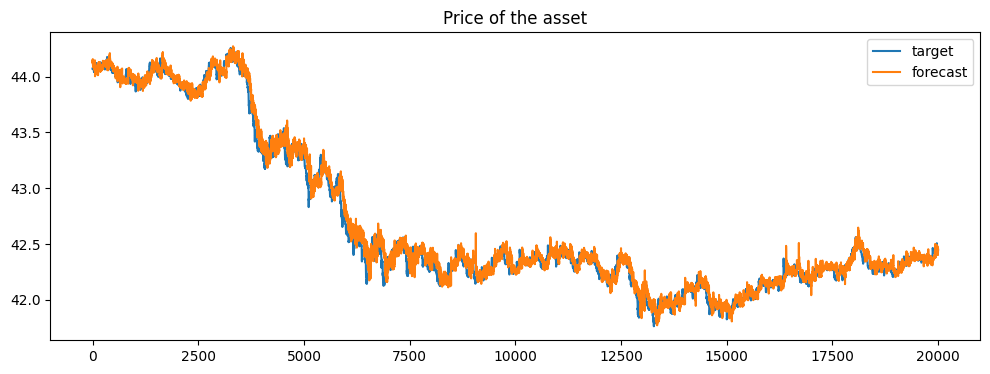

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(target, label='target')
plt.plot(pred, label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()

Example of 1000 forecasts.

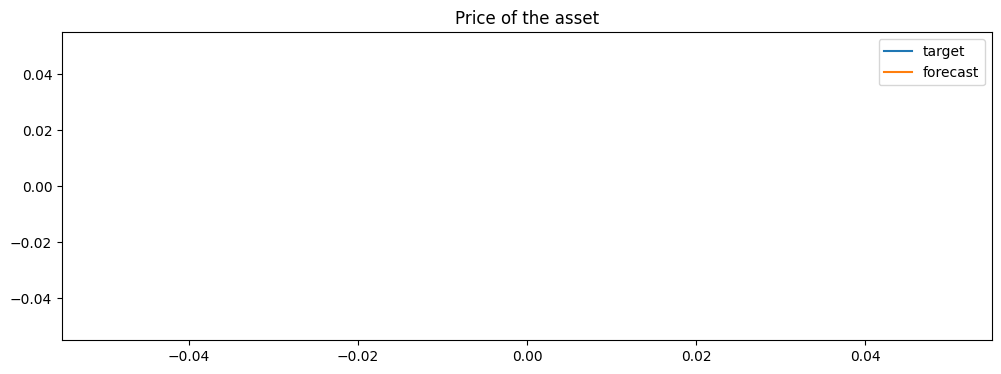

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(target[-100000:-99000], label='target')
plt.plot(pred[-100000:-99000], label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()